<a href="https://colab.research.google.com/github/devtico/winequality/blob/master/vinho_branco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Predição da qualidade do vinho </h1>

In [ ]:
%%capture
! pip install dtreeviz # pacote para visualizar o resultado
import pandas as pd
import os
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
import dtreeviz.trees as trv

##Baixando os bancos de dados

In [ ]:
tinto = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

In [ ]:
#branco = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

In [ ]:
tinto

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Normalizando os valores de densidade:

In [ ]:
def zscore(x):
  return (x - np.mean(x)) / np.std(x)

In [ ]:
tinto.density = zscore(tinto.density)

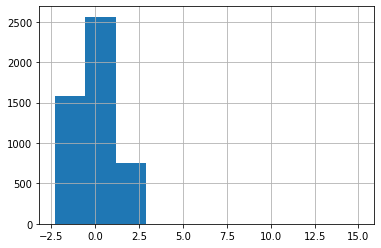

In [ ]:
tinto.density.hist()

Quantas valores de qualidade diferentes existem?

In [ ]:
tinto.quality.value_counts(sort=False)

4     163
8     175
5    1457
9       5
6    2198
3      20
7     880
Name: quality, dtype: int64

## Preparação dos dados para o modelo
20% para teste 80% para treino

In [ ]:
tinto_X_train, tinto_X_test, tinto_Y_train, tinto_Y_test = train_test_split(
    tinto.iloc[:, 0:11],
    tinto.quality,
    test_size=0.2,
    random_state=1234,
    stratify=tinto.quality)

## Árvore de decisão

In [ ]:
modelo_tinto = DecisionTreeClassifier(min_samples_leaf=50,
                                      min_impurity_decrease=0.01,
                                      class_weight='balanced',
                                      random_state=1234)

In [ ]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int or None, optional (default=None)
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int, float, optional (default=2)

In [ ]:
modelo_tinto.fit(tinto_X_train, tinto_Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.01, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


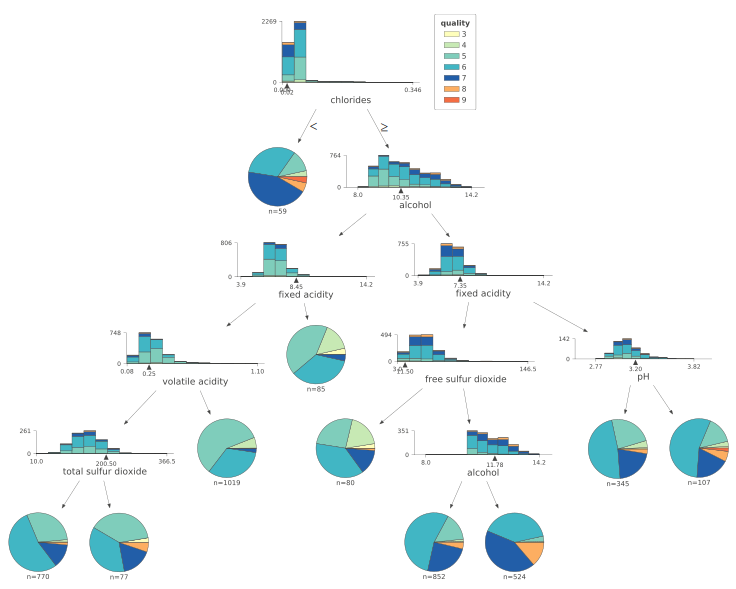

In [ ]:
viz = trv.dtreeviz(modelo_tinto,
                   tinto_X_train,
                   tinto_Y_train,
                   target_name='quality',
                   feature_names = tinto.iloc[:,0:11].columns,
                   class_names=['3', '4', '5', '6', '7', '8', '9']);
viz

## Avaliando o modelo
percentual de acertos:

In [ ]:
accuracy_score(tinto_Y_test, modelo_tinto.predict(tinto_X_test))

0.32142857142857145

Matriz de confusão

In [ ]:
confusion_matrix(tinto_Y_test, modelo_tinto.predict(tinto_X_test))

array([[  1,   0,   1,   1,   1,   0,   0],
       [ 12,   0,  12,   3,   5,   0,   1],
       [ 44,   0, 149,  48,  36,   6,   8],
       [ 61,   0,  78, 104, 117,  64,  16],
       [ 25,   0,   6,  23,  47,  69,   6],
       [  5,   0,   0,   3,  11,  14,   2],
       [  0,   0,   0,   0,   0,   1,   0]])

Nova métrica: diferença de qualidade

In [ ]:
def abs_dif(y_true, y_pred):
  return np.mean(np.abs(y_true - y_pred))

In [ ]:
abs_dif(tinto_Y_test, modelo_tinto.predict(tinto_X_test))

1.1551020408163266

##Otimização do modelo

In [ ]:
parametros = {'min_samples_leaf': [10, 20 ,30, 40, 50, 60, 70, 80, 90, 100],
              'min_impurity_decrease': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
              'class_weight': ['balanced', None],
              'splitter':['best', 'random'],
              'max_depth': [3, 4, 5, None],
              'criterion': ['gini', 'entropy']}
tinto_opt = GridSearchCV(modelo_tinto, parametros,
                         cv=4,
                         iid=False,
                         scoring=make_scorer(abs_dif, greater_is_better=False))

In [ ]:
tinto_opt.fit(tinto_X_train, tinto_Y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.01,
                                              min_impurity_split=None,
                                              min_samples_leaf=50,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1234,
                                              splitter='best'),
             iid=...
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         

In [ ]:
tinto_opt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.005, min_impurity_split=None,
                       min_samples_leaf=40, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

Árvore otimizada

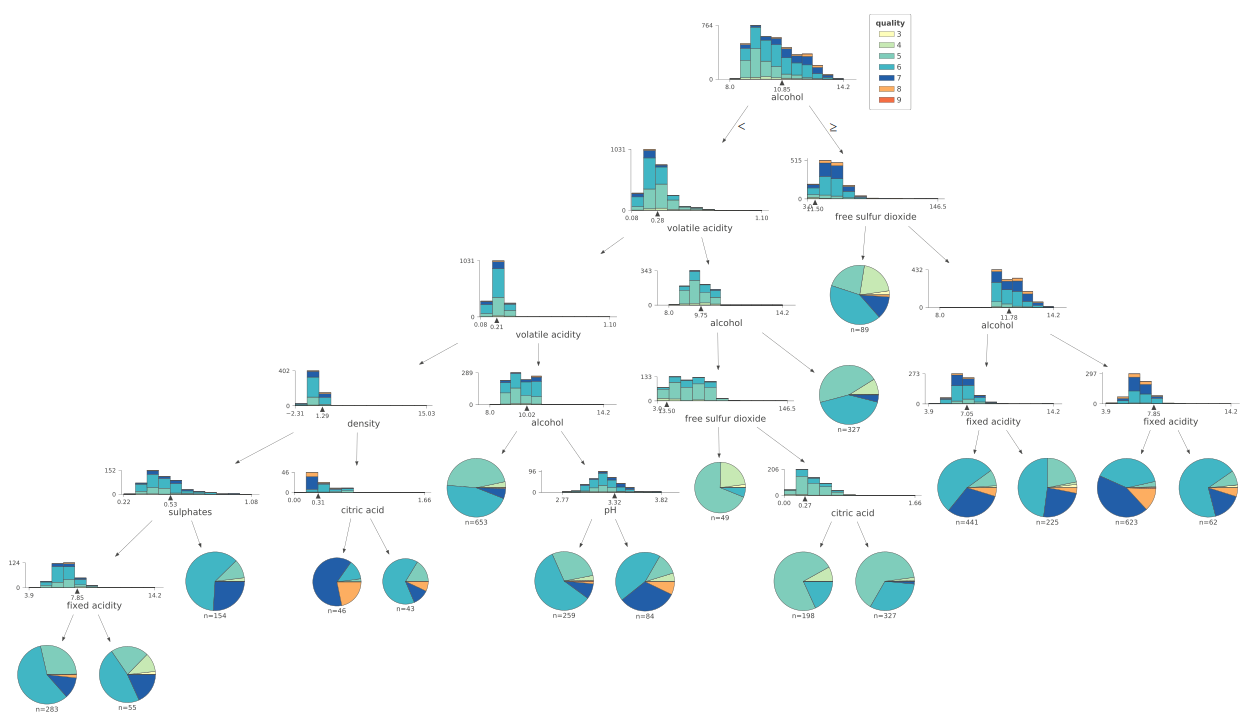

In [ ]:
viz = trv.dtreeviz(tinto_opt.best_estimator_,
                   tinto_X_train,
                   tinto_Y_train,
                   target_name='quality',
                   feature_names = tinto.iloc[:,0:11].columns,
                   class_names=['3', '4', '5', '6', '7', '8','9']);
viz

##Avaliando modelo otimizado

percentual de acerto

In [ ]:
accuracy_score(tinto_Y_test, tinto_opt.predict(tinto_X_test))

0.5071428571428571

Diferença absoluta

In [ ]:
abs_dif(tinto_Y_test, tinto_opt.predict(tinto_X_test))

0.5551020408163265

Matriz confusão

In [ ]:
pd.DataFrame(
    confusion_matrix(tinto_Y_test, tinto_opt.predict(tinto_X_test)),
                 index=pd.MultiIndex.from_product([["True"],
                                                   ["3", "4", "5", "6", "7", "8", '9']]),
                 columns=pd.MultiIndex.from_product([["Predicted"],
                                                     ["3", "4", "5", "6", "7", "8", '9']]))

Predicted                       
               3  4    5    6   7  8  9
True 3         0  0    3    1   0  0  0
     4         0  0   20   13   0  0  0
     5         0  0  196   86   9  0  0
     6         0  0  147  219  74  0  0
     7         0  0   18   76  82  0  0
     8         0  0    0   15  20  0  0
     9         0  0    0    0   1  0  0